# Section 1) Data extraction.

## Here we extract light curves from our three energy bands, interpolate and rebin them, and derive their cross correlation functions.

## No modelling is performed in this section.

In [9]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'style'  : 'italic',
        'size'   : 15} # or 10 for triplot
matplotlib.rc('font', **font)
%matplotlib inline
import scipy.optimize
pi = np.pi

## Extract the raw light curves, and set up time bins in each.

In [10]:
data = np.genfromtxt("raw_lightcurves/ARK120/ark_120_u.txt")
MJD_U = data[:,0]
flux_U = data[:,1]
flux_err_U = data[:,2]

data = np.genfromtxt("raw_lightcurves/ARK120/ark_120_xrt.txt")
MJD_X = data[:,0]
flux_X = data[:,1]
flux_err_X = data[:,2]

data = np.genfromtxt("raw_lightcurves/ARK120/ark_120_uvm2.txt")
MJD_UVM2 = data[:,0]
flux_UVM2 = data[:,1]
flux_err_UVM2 = data[:,2]

dt_U = MJD_U[1:] - MJD_U[:-1]

dt_X = MJD_X[1:] - MJD_X[:-1]

dt_UVM2 = MJD_UVM2[1:] - MJD_UVM2[:-1]

## Now we interpolate the lightcurves as they were irregularly binned.

In [11]:
dt_dat= 0.05

comparison_times = np.arange(MJD_UVM2[0], MJD_UVM2[-1], dt_dat)
flux_U_int = np.interp(comparison_times, MJD_U, flux_U)
flux_X_int = np.interp(comparison_times, MJD_X, flux_X)
flux_UVM2_int = np.interp(comparison_times, MJD_UVM2, flux_UVM2)
flux_err_U_int = np.interp(comparison_times, MJD_U, flux_err_U)
flux_err_X_int = np.interp(comparison_times, MJD_X, flux_err_X)
flux_err_UVM2_int = np.interp(comparison_times, MJD_UVM2, flux_err_UVM2)

## Now we can rebin the lightcurves to obtain a more reliable signal/noise. These are the lightcurves we will model later on.

In [12]:
dt_rebn = 0.5

bins = np.arange(MJD_UVM2[0], MJD_UVM2[-1], dt_rebn)
digitized = np.digitize(comparison_times[3:-3], bins)
comparison_times_rebn = np.asarray([comparison_times[3:-3][digitized == i].mean() for i in range(1, len(bins))])
flux_U_rebn = np.asarray([flux_U_int[3:-3][digitized == i].mean() for i in range(1, len(bins))])
flux_X_rebn = np.asarray([flux_X_int[3:-3][digitized == i].mean() for i in range(1, len(bins))])
flux_UVM2_rebn = np.asarray([flux_UVM2_int[3:-3][digitized == i].mean() for i in range(1, len(bins))])
flux_err_U_rebn = np.asarray([flux_err_U_int[3:-3][digitized == i].mean() for i in range(1, len(bins))])
flux_err_X_rebn = np.asarray([flux_err_X_int[3:-3][digitized == i].mean() for i in range(1, len(bins))])
flux_err_UVM2_rebn = np.asarray([flux_err_UVM2_int[3:-3][digitized == i].mean() for i in range(1, len(bins))])

## Now we can plot the rebinned light curves and have a look at them.

Text(0,0.5,'X')

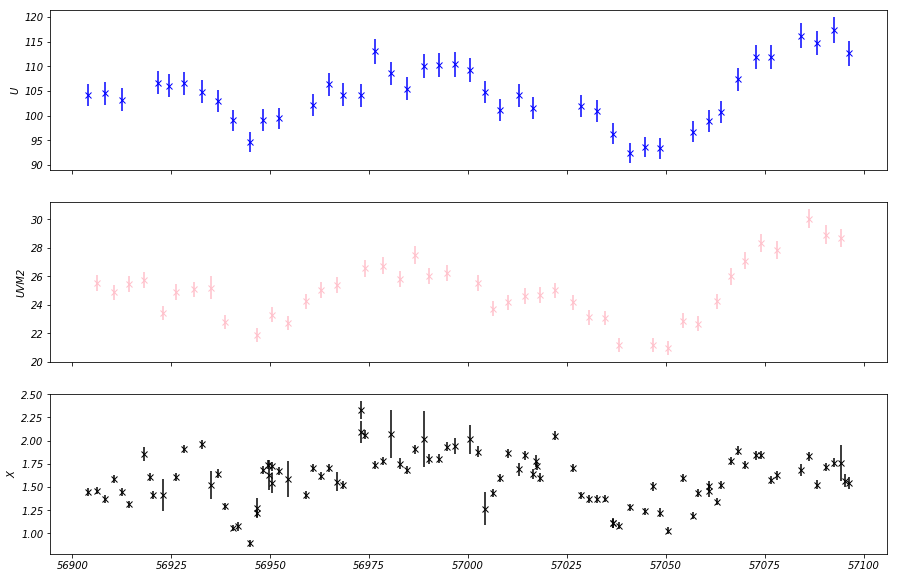

In [13]:
f, (ax3, ax5, ax8) = plt.subplots(3, sharex = True, figsize=  (15, 10))
ax3.errorbar(MJD_U, flux_U, flux_err_U, label = 'U', c='b', ls = 'none', fmt = 'x')
ax3.set_ylabel('U')
ax5.errorbar(MJD_UVM2, flux_UVM2, flux_err_UVM2 , label = 'UVM2', c='pink', ls = 'none', fmt = 'x')
ax5.set_ylabel('UVM2')
ax8.errorbar(MJD_X, flux_X, flux_err_X, label = 'X', c='k', ls = 'none', fmt = 'x')
ax8.set_ylabel('X')

## Now we will produce cross-correlation functions (CCFs) between our UVM2 band and the other two. To do this we will define the CCF.

In [14]:
taus = np.arange(-20, 20, dt_rebn)

def CCF(s, h, dt, s_err = 0, h_err=0, s_int_err = 0, h_int_err = 0):  
    
    if type(s_err)==int :
        s_err = np.zeros(len(s))
    if type(h_err)==int:
        h_err = np.zeros(len(h))
    
    lens = len(s)

    corrs = np.zeros(len(taus))
    
    for j in range(len(taus)):
        tau = taus[j]
        di = int(tau/dt)
        if abs(di) < lens:
            if di > 0:
                '''Imagine s staying fixed and h 'rolling' forward by di beneath it.'''
                s_up = s[:-di]
                s_err_up = s_err[:-di]
                h_up = h[di:]
                h_err_up = h_err[di:]
            elif di == 0:
                s_up = s
                s_err_up = s_err
                h_up = h
                h_err_up = h_err
            else:
                s_up = s[abs(di):]
                s_err_up = s_err[abs(di):]
                h_up = h[:-abs(di)]
                h_err_up = h_err[:-abs(di)]     
            save = np.average(s_up)
            have = np.average(h_up)
            sig_s = np.var(s_up)
            sig_h = np.var(h_up)
            sig_s_err = np.var(s_err_up)
            sig_h_err = np.var(h_err_up)
            lens_up = len(s_up)
            
            corrs[j] = np.sum((s_up - save) * (h_up - have)) / lens_up
            corrs[j] = corrs[j] / ((sig_s * (1 - s_int_err) - sig_s_err) * (sig_h * (1-h_int_err) - sig_h_err))**0.5
        
    return corrs

## We should also correct for interpolation error as in Gardner & Done 2017. This requires that we define a gaussian function and fit our raw CCF using two gaussian functions; the narrow central gaussian will be spurious, and so we can quantify the interpolation error in terms of the narrow gaussian parameters.

In [15]:
def gaussian(x, amp_A, sig2_A, amp_B, sig2_B, K):
    return amp_A / np.sqrt(2*pi*sig2_A) * np.exp( - (x)**2 / (2*sig2_A)) + amp_B / np.sqrt(2*pi*sig2_B) * np.exp( - (x)**2 / (2*sig2_B)) + K

def CCF_corrected(s, h, dt, s_err, h_err, mode = 'corr'):
    if mode == 'corr':
        ACF_s = CCF(s, s, dt_rebn, s_err, s_err)
        params_s = scipy.optimize.curve_fit(gaussian,taus,ACF_s, maxfev = 500000)[0]
        
        ACF_h = CCF(h, h, dt_rebn, h_err, h_err)
        params_h = scipy.optimize.curve_fit(gaussian,taus,ACF_h, maxfev = 500000)[0]
        
        sig2_e_s_rat = min(params_s[1], params_s[3]) / max(params_s[1], params_s[3])
        sig2_e_h_rat = min(params_h[1], params_h[3]) / max(params_h[1], params_h[3])
    
        CCF_corr = CCF(s, h, dt, s_err, h_err, sig2_e_s_rat, sig2_e_h_rat)
    if mode == 'nocorr':
        CCF_corr = CCF(s, h, dt, s_err, h_err) 

    return CCF_corr[::-1]


## Now we can plot the corrected CCFs of our data and compare them.

/home/raad/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/home/raad/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Text(0,0.5,'normalised CCF')

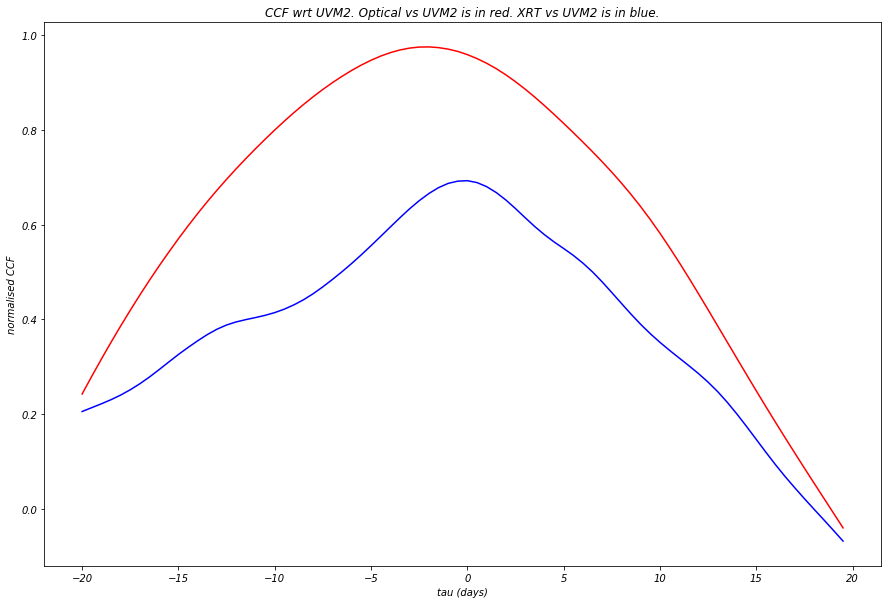

In [16]:
CCF_X = CCF_corrected(flux_UVM2_rebn, flux_X_rebn, dt_rebn, flux_err_UVM2_rebn, flux_err_X_rebn)
CCF_U = CCF_corrected(flux_UVM2_rebn, flux_U_rebn, dt_rebn, flux_err_UVM2_rebn, flux_err_U_rebn)

f, ax = plt.subplots(figsize = (15,10))
ax.plot(taus, CCF_X, c = 'blue')
ax.plot(taus, CCF_U, c = 'red')
ax.set_title('CCF wrt UVM2. Optical vs UVM2 is in red. XRT vs UVM2 is in blue.')
ax.set_xlabel('tau (days)')
ax.set_ylabel('normalised CCF')